# Import Dataset and Libraries

In [139]:
# Standarc library imports
from collections import defaultdict
from random import randrange
from tqdm import tqdm
from typing import Any
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, hamming_loss, jaccard_score,
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

DO_OPTIMIZATION = False
RANDOM_STATE = 42
TEST_SIZE = 0.2
ROYALBLUE = "#4169E1"

In [98]:
warnings.filterwarnings(action='ignore')    # 주피터 노트북 에러 로그 무시하는 코드
%config Completer.use_jedi = False          # Tab 키를 누르면 자동 완성 목록을 활성화하는 코드
plt.rc('font', family='Malgun Gothic')      # plt로 한글 폰트 사용하는 코드

In [99]:
STD_PATH = "."
TRAIN_FILE = f"{STD_PATH}/train.csv"
TEST_FILE = f"{STD_PATH}/test.csv"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

is_pregnant = df_train.columns[-1]
X, y = df_train.drop(is_pregnant, axis=1), df_train[is_pregnant]
X_test = df_test.drop(is_pregnant, axis=1) if is_pregnant in df_test else df_test

# EDA

In [100]:
def draw_imbalance_barplot(df: pd.DataFrame, title: str, width: int=10, height: int=2) -> None:
    df[title].value_counts().plot.bar(
        color='royalblue',
        figsize = (width, height),
    )    
    plt.title(title)
    plt.xlabel(f"{title} 컬럼의 데이터 종류")
    plt.ylabel('데이터 개수')
    plt.grid(True, linestyle='--', linewidth=0.3, axis='y')
    return

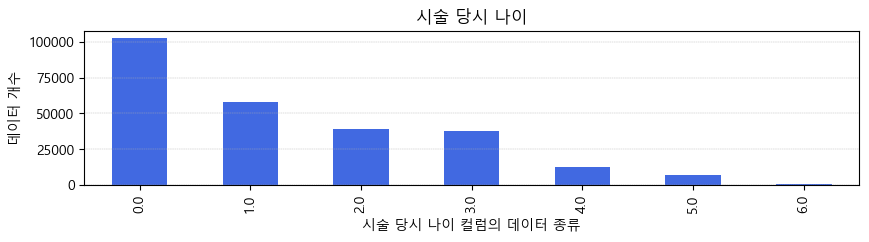

In [132]:
# 테스트용 그래프 그리기(무작위 컬럼)
random_column = X.columns.tolist()[randrange(1, len(X.columns.tolist()))]
draw_imbalance_barplot(X, random_column)

In [122]:
def draw_heatmap(df: pd.DataFrame, method: str='pearson', width: int=8, height: int=8) -> None:
    # method: pearson(default), kendall, spearman
    # interpolation: None(default), nearest, bilinear, bicubic, gaussian, hanning, hamming, lanczos, none
    
    corr_matrix = df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))    
    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
    return

In [103]:
# 테스트용 그래프 그리기
# draw_heatmap(X, width=50, height=50)

In [104]:
# X.info()
float64_columns = X.select_dtypes(include='float64').columns.tolist()
int64_columns = X.select_dtypes(include='int64').columns.tolist()
object_columns = X.select_dtypes(include='O').columns.tolist()

# Data Preprocessing

### 1. Feature Cleaning

In [105]:
# """
# - Missing values(drop, mean, median, mode, KNNImputer, MICE)
# - Outliers (IQR, log)
# - Feature selection(remove duplicates, VIF)
# """

In [106]:
values = {
    **{column: 0 for column in float64_columns},
    **{column: 0 for column in int64_columns},
    **{column: "0" for column in object_columns}
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

### 2. Feature Engineering

In [107]:
# """
# - Feature Creation
# - Feature Transformation(log, sqrt, min-max scaling)
# - Feature Extraction(PCA, LDA, heatmap)
# """

### 3. Feature Encoding

In [108]:
# """
# - LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
# """

In [109]:
encoder = OrdinalEncoder()

X[object_columns] = encoder.fit_transform(X[object_columns])
X_test[object_columns] = encoder.fit_transform(X_test[object_columns])

### 4. Feature Removal

In [110]:
drop_features = [
    # 'ID',
    #  '시술 시기 코드',
    #  '시술 당시 나이',
    #  '임신 시도 또는 마지막 임신 경과 연수',
    #  '시술 유형',
    #  '특정 시술 유형',
    #  '배란 자극 여부',
    #  '배란 유도 유형',
    #  '단일 배아 이식 여부',
    #  '착상 전 유전 검사 사용 여부',
    #  '착상 전 유전 진단 사용 여부',
    #  '남성 주 불임 원인',
    #  '남성 부 불임 원인',
    #  '여성 주 불임 원인',
    #  '여성 부 불임 원인',
    #  '부부 주 불임 원인',
    #  '부부 부 불임 원인',
    #  '불명확 불임 원인',
    #  '불임 원인 - 난관 질환',
    #  '불임 원인 - 남성 요인',
    #  '불임 원인 - 배란 장애',
    #  '불임 원인 - 여성 요인',
    #  '불임 원인 - 자궁경부 문제',
    #  '불임 원인 - 자궁내막증',
    #  '불임 원인 - 정자 농도',
    #  '불임 원인 - 정자 면역학적 요인',
    #  '불임 원인 - 정자 운동성',
    #  '불임 원인 - 정자 형태',
    #  '배아 생성 주요 이유',
    #  '총 시술 횟수',
    #  '클리닉 내 총 시술 횟수',
    #  'IVF 시술 횟수',
    #  'DI 시술 횟수',
    #  '총 임신 횟수',
    #  'IVF 임신 횟수',
    #  'DI 임신 횟수',
    #  '총 출산 횟수',
    #  'IVF 출산 횟수',
    #  'DI 출산 횟수',
    #  '총 생성 배아 수',
    #  '미세주입된 난자 수',
    #  '미세주입에서 생성된 배아 수',
    #  '이식된 배아 수',
    #  '미세주입 배아 이식 수',
    #  '저장된 배아 수',
    #  '미세주입 후 저장된 배아 수',
    #  '해동된 배아 수',
    #  '해동 난자 수',
    #  '수집된 신선 난자 수',
    #  '저장된 신선 난자 수',
    #  '혼합된 난자 수',
    #  '파트너 정자와 혼합된 난자 수',
    #  '기증자 정자와 혼합된 난자 수',
    #  '난자 출처',
    #  '정자 출처',
    #  '난자 기증자 나이',
    #  '정자 기증자 나이',
    #  '동결 배아 사용 여부',
    #  '신선 배아 사용 여부',
    #  '기증 배아 사용 여부',
    #  '대리모 여부',
    #  'PGD 시술 여부',
    #  'PGS 시술 여부',
    #  '난자 채취 경과일',
    #  '난자 해동 경과일',
    #  '난자 혼합 경과일',
    #  '배아 이식 경과일',
    #  '배아 해동 경과일'
]

X = X.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

# Hyperparameter Tuning

In [141]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C

In [111]:
def optimize() -> None:
    return


if DO_OPTIMIZATION:
    optimize()

# Modeling

### 1. Import

In [112]:
# Model imports
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [113]:
clf_model_dict = {
    "adaboost": AdaBoostClassifier(),
    "gradient": GradientBoostingClassifier(),
    "random_forest": RandomForestClassifier(),
    "lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "svc": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier(),
    "catboost": CatBoostClassifier(verbose=False),
    "lgbm": LGBMClassifier(),
    "xgb": XGBClassifier(),
}

### 2. Training

In [114]:
def eval(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    # is CatBoostClassifier
    if isinstance(y_pred[0], str):
        accuracy = accuracy_score(y, y_pred)                        # 정확도
        precision = precision_score(y, y_pred, pos_label='True')    # 정밀도
        recall = recall_score(y, y_pred, pos_label='True')          # 재현율
        f1 = f1_score(y, y_pred, pos_label='True')                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)                         # ROC-AUC 점수
        
    else:
        accuracy = accuracy_score(y, y_pred)      # 정확도
        precision = precision_score(y, y_pred)    # 정밀도
        recall = recall_score(y, y_pred)          # 재현율
        f1 = f1_score(y, y_pred)                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

### 3. K-Fold Cross Validation

In [116]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = []
score_types = ["Accuracy", "Precision", "Recall", "F1-Score", "Roc-Auc"]

model = clf_model_dict["adaboost"]

for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    scores = eval(model, X_test, y_test)
    roc_auc_scores.append(scores[-1])

    for score_type, score in zip(score_types, scores):
        print(f"{score_type} (Fold {idx}): {score}")
    print()

print(f"Cross-Validation Average F1-Score: {np.mean(roc_auc_scores)}")

Accuracy (Fold 0): 0.7452165941760449
Precision (Fold 0): 0.5480314960629922
Recall (Fold 0): 0.07881624641401178
F1-Score (Fold 0): 0.13781268563131147
Roc-Auc (Fold 0): 0.7180017298710895

Accuracy (Fold 1): 0.7419153501072752
Precision (Fold 1): 0.5033836543466944
Recall (Fold 1): 0.07300868252170631
F1-Score (Fold 1): 0.12752208888302782
Roc-Auc (Fold 1): 0.7218875156392361

Accuracy (Fold 2): 0.742441973863858
Precision (Fold 2): 0.5097751710654936
Recall (Fold 2): 0.07874669686674217
F1-Score (Fold 2): 0.13642011640834478
Roc-Auc (Fold 2): 0.7226259988200924

Accuracy (Fold 3): 0.7423249463623952
Precision (Fold 3): 0.5095890410958904
Recall (Fold 3): 0.07020987467914842
F1-Score (Fold 3): 0.12341583172981223
Roc-Auc (Fold 3): 0.7223867023962774

Accuracy (Fold 4): 0.7438853130485664
Precision (Fold 4): 0.5306666666666666
Recall (Fold 4): 0.07511701645779859
F1-Score (Fold 4): 0.13160505257588784
Roc-Auc (Fold 4): 0.7229760245990366

Cross-Validation Average F1-Score: 0.721575594

# Visualization

<Axes: >

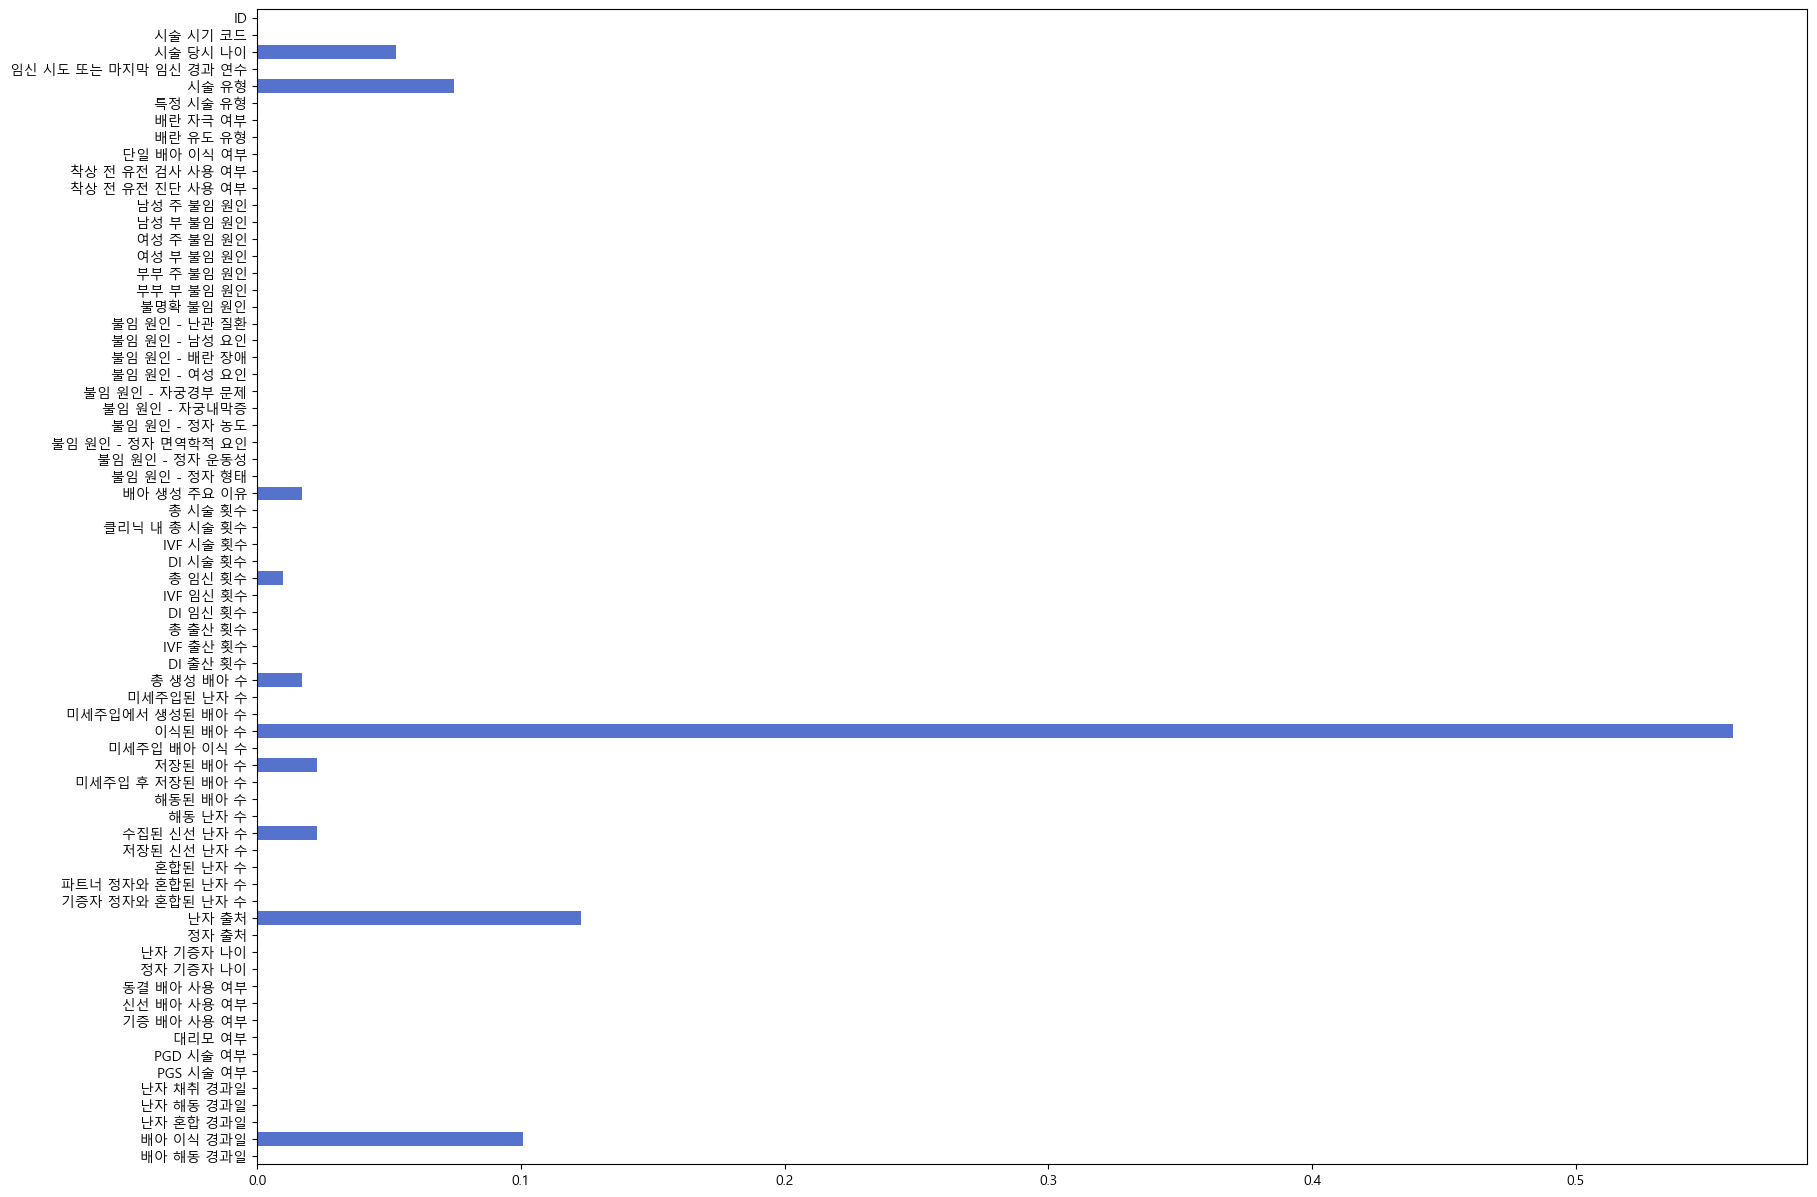

In [140]:
feature_names = X.columns.tolist()
plt.figure(figsize=(20,15))
sns.barplot(x=model.feature_importances_, y=feature_names, palette=[ROYALBLUE])

# Create Submission

In [ ]:
# # Final Submission
# X.to_csv("submission.csv", index=False)